In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image (1102, 746, 3)


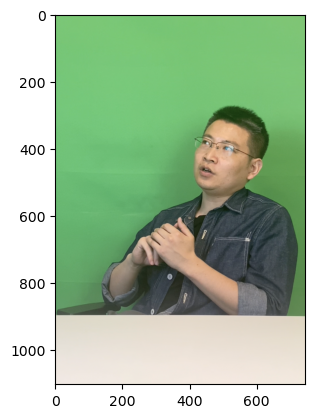

In [3]:
# load image

input_mean = 0.0
input_std = 1.0

img_path = "./align_img/fangzi.jpg"
image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # origin image in BGR
img = np.float32(image)

im_height, im_width, _ = img.shape
scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
scale = scale.to(device)


img -= (104, 117, 123) # mean substruction to reduce illumination changes
img = img.transpose(2, 0, 1)[None, :]

Batch_size = img.shape[0]

# show the origin image
# plt.imshow(image[:,:,::-1]/255)
plt.imshow(image[:,:,::-1]/255)

print("image",image.shape)

In [4]:
# input_shape2 = B*3*192*192

feed_img = torch.tensor(image,device=device).float()
feed_img = feed_img.permute(2,0,1).unsqueeze(0)

B,C,H,W = feed_img.shape

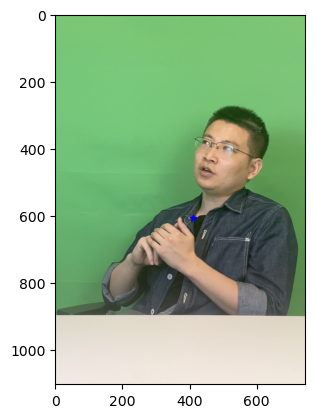

In [5]:
center = torch.tensor(feed_img.shape[-2:],device=device)

abstract_key_point = center*1.1
abstract_key_point_np = abstract_key_point.cpu().numpy()/2
plt.imshow(feed_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])
plt.scatter(abstract_key_point_np[1], abstract_key_point_np[0], c='b',  s=20, marker='*')

/home/hermit_delta/miniconda3/envs/Human3D/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


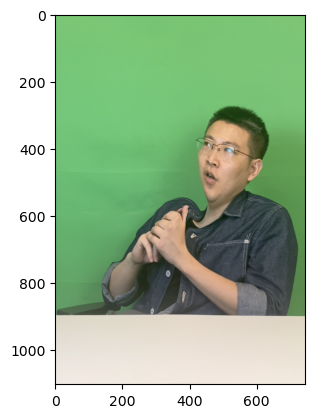

In [11]:
grid = F.affine_grid(torch.eye(3,device=device).unsqueeze(0)[:,0:2,:], torch.Size((B, C, H, W)))
#grid = (grid+1.0)*center.view(B,1,1,2)

abstract_key_point_normalized = (abstract_key_point - center)/center
dist = torch.norm(grid - abstract_key_point_normalized.repeat(B,1,1,1),dim=-1,keepdim=True)
k = 1e1
exp_minus_dist = torch.exp(-k*dist)
exp_minus_dist = torch.where(exp_minus_dist>1e-4,exp_minus_dist,torch.zeros_like(exp_minus_dist))

exp_minus_dist.max()

angle = torch.tensor(120.0,device=device)
             
theta = angle * torch.pi / 180.0

trans = 0*torch.tensor([20, 20],device=device)

trans_normalized = trans/center


scale = torch.tensor(1.5,device=device)

#rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]],device=device)

theta_grid = theta.repeat(B,H,W,1)*exp_minus_dist


rotation_matrix_grid = torch.cat([torch.cos(theta_grid), torch.sin(theta_grid), -torch.sin(theta_grid), torch.cos(theta_grid)], dim=-1).view(B,H,W,2,2)


trans_grid = trans_normalized.repeat(B,H,W,1)*exp_minus_dist

scale_grid = (scale.repeat(B,H,W,1)*exp_minus_dist)/2+1

affine_grid = rotation_matrix_grid.matmul(((grid - abstract_key_point_normalized.repeat(B,H,W,1))*scale_grid).unsqueeze(-1)).squeeze(-1)+abstract_key_point_normalized.repeat(B,H,W,1)+trans_grid

affine_img = F.grid_sample(feed_img, affine_grid)


plt.imshow(affine_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])


